### Bailey Griswold
bg1672  
PUI, Fall 2016  
December 10, 2016  
Professor Bianco  

### HW 11

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import shapely
import os
import zipfile
PUIDATA = os.getenv('PUIDATA')

*** 1. Download census tract shape file from data from nyc.gov ***  
http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

In [220]:
# This block of code is from Ben Alpert
##Get Census tract shape file, move to PUIDATA folder, and read it using Geopandas into a dataframe. 
!curl -O "http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip"
os.rename("nycb2010_16d.zip", "nyc_census_shape_file.zip")
shapefile="nyc_census_shape_file.zip"
os.system("mv " + shapefile + " " + os.getenv("PUIDATA"))
zf = zipfile.ZipFile(PUIDATA + "/" + shapefile, mode='r')
zf.extractall(PUIDATA + "/" +  "nyc_census_shape_file/")
zf.close()
shapefile = PUIDATA +"/nyc_census_shape_file/nycb2010_16d"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5616k  100 5616k    0     0  55.3M      0 --:--:-- --:--:-- --:--:-- 63.7M


In [223]:
#from Ben Alpert
shape_path = shapefile
ct_shape = GeoDataFrame.from_file(shape_path)

In [224]:
# a view of the shape file loaded as a geojson file will look like this. Notice the coordinates. They are in 
# epsg=2263 is US feet. You want to convert them in epsg=4326: lat/on . 
# Look at the notebook https://github.com/fedhere/PUI2016_fb55/blob/master/Lab9_SRK325/GeospatialAnalysis_CitiBike.ipynb
#from_epsg(4326)
ct_shape.crs = from_epsg(2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

In [225]:
ct_latlon = ct_shape.to_crs(epsg=4326)
ct_latlon.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,POLYGON ((-74.07920577013245 40.64343078374566...
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438018 40.61085506705415...
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,POLYGON ((-74.07524403910642 40.62600632452711...
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,POLYGON ((-74.08708799689826 40.61116883123923...
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511992 40.60100160655585...


**2. Extract only the Brooklyn shape polygons and convert the coordinates to lat/lon**

In [226]:
ct_latlon = ct_latlon[ct_latlon.BoroName == 'Brooklyn']
ct_latlon.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
5038,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384567195...
5039,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,POLYGON ((-73.99270830309769 40.69809925981344...
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,POLYGON ((-73.98514306089652 40.69488514296981...
5041,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793354038...


***3.. Find the coordinates of CUSP: 1 MetroTech Brooklyn. Create a Point shapely geometry with the coordinates of CUSP***

    shapely.geometry.Point()

In [227]:
# Coordinates of CUSP = 40.693088, -73.986853

cusp = shapely.geometry.Point(-73.986853, 40.693088)

***4. Loop over the Brookly polygons (nearly 10000) and assess find in which geometry the polygon is contained***

In [235]:
ct_latlon.geometry

5037     POLYGON ((-74.00659158337982 40.65561273365177...
5038     POLYGON ((-73.99514512602698 40.69877384567195...
5039     POLYGON ((-73.99270830309769 40.69809925981344...
5040     POLYGON ((-73.98514306089652 40.69488514296981...
5041     POLYGON ((-73.98305147125492 40.69837793354038...
5042     POLYGON ((-74.01298705619367 40.64945600085578...
5043     POLYGON ((-74.01925526318796 40.64685276170034...
5044     POLYGON ((-74.02626267406124 40.6400943813377,...
5045     POLYGON ((-73.97782679465361 40.69343813939842...
5046     POLYGON ((-73.97510566428164 40.68969750917618...
5047     POLYGON ((-73.97551988364876 40.68675683608991...
5048     POLYGON ((-73.98092822918812 40.68890247777631...
5049     POLYGON ((-74.03231651986361 40.63479116049513...
5050     POLYGON ((-73.98181677514269 40.68732980226248...
5051     POLYGON ((-73.98872146849779 40.68924580848416...
5052     POLYGON ((-74.03315548281147 40.63273497322291...
5053     POLYGON ((-73.99236367043248 40.68969012377696.

In [262]:
# you will need to use 
# - ct_latlon.geometry (the polygons you are looping over)
# - shapely.geometry.asShape(<the polygon>).contain(<the point>)
# - save the index of the polygon that contains the CUSP
for i in ct_latlon.index:
    polygon = ct_latlon.geometry[i]
    if shapely.geometry.asShape(polygon).contains(cusp):
        ct_cusp = ct_latlon.BCTCB2010[i]#code from Ben Alpert
        print('CUSP is contained in', ct_cusp)
        break
    else: 
        continue

CUSP is contained in 30011001008


*** 5. Plot one every 10 polygons of brooklyn (using the geopandas datafame method plot)
and overplot the locati`on of cusp as a point (using pylab.scatter)
Overplot also the census track that contains cusp in red (using the geopandas datafame method plot)***

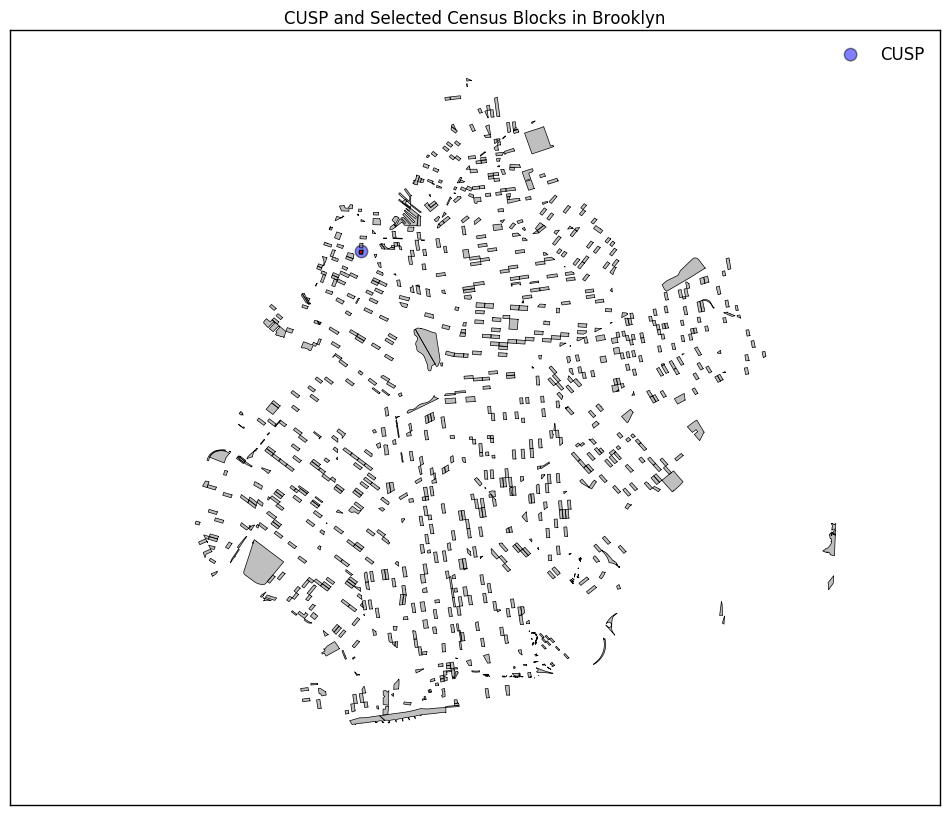

In [279]:
f, ax = plt.subplots(figsize=(12,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_latlon.iloc[::10].plot(column='BoroCode',color='gray', alpha=.5,linewidth=0.5,ax=ax)
ax.scatter(cusp.x, cusp.y, s=80, c='blue', alpha=.5, label='CUSP')
ct_latlon[(ct_latlon.BCTCB2010 == ct_cusp)].plot(color='red', alpha=1, ax=ax)#code from Ben Alpert
ax.set_title('CUSP and Selected Census Blocks in Brooklyn')
ax.legend(scatterpoints=1, frameon=False)